## 1 - Load Dataset

In [1]:
from dataset import ogb_dataset_to_nx_graph

dataset_name = 'ogbn-arxiv'

graph = ogb_dataset_to_nx_graph(dataset_name)

print(f'# of Nodes: {graph.number_of_nodes():_}\n# of Edges: {graph.number_of_edges():_}')

# of Nodes: 169_343
# of Edges: 1_157_799


## 2 - Sample Random Subgraph

In [2]:
import random
from tqdm import tqdm
import numpy as np
from graph import SubgraphHandler

subgraph_size = 100

# Get an initial subgraph node set
#subgraph_nodes = list(np.random.choice(graph.nodes(), size=(subgraph_size), replace=False))
subgraph_nodes = list(np.load('0.151-60k.npy'))

subgraph = SubgraphHandler(
    full_graph = graph, 
    initial_node_set = subgraph_nodes
)

print(f'Initial KS Distance: {subgraph.ks_distance()}')

Initial KS Distance: 0.15146843979379132


## 3 - Metropolis-Hastings

In [3]:
from logger import RunHistory

logger = RunHistory(subgraph_handler=subgraph,
                    save_interval=100)

In [4]:
num_iters = 5_000

print(f'Saving every {logger.save_interval:_} iterations for a total of {num_iters // logger.save_interval} saves over {num_iters:_} iterations.')

exponent = 99

Saving every 100 iterations for a total of 50 saves over 5_000 iterations.


In [5]:
prev_ks_dist = subgraph.ks_distance()

for i in (pbar := tqdm(range(num_iters))):
    # Randomly pick a node to remove and add to the subgraph
    remove_node = np.random.choice(subgraph.nodes)
    add_node = np.random.choice(subgraph.nodes_not_in_subgraph)

    subgraph.remove(remove_node)
    subgraph.add(add_node)

    # Calculate the new Degree KS Distance
    new_ks_dist = subgraph.ks_distance()

    ratio = prev_ks_dist / new_ks_dist
    if ratio >= 1.0:
        # Accept
        prev_ks_dist = new_ks_dist
        accepted = True
    else:
        score = ratio ** exponent
        prop = random.random()
        if score > prop:
            # Accept
            prev_ks_dist = new_ks_dist
            accepted = True
        else:
            # Reject and revert back
            subgraph.add(remove_node)
            subgraph.remove(add_node)
            accepted = False

    pbar.set_description(f'KS Dist: {prev_ks_dist:.5}')
    logger.log(ratio=ratio, accepted=accepted)

KS Dist: 0.66833: 100%|██████████| 5000/5000 [05:14<00:00, 15.88it/s]


Acceptance Ratio: 45.66%


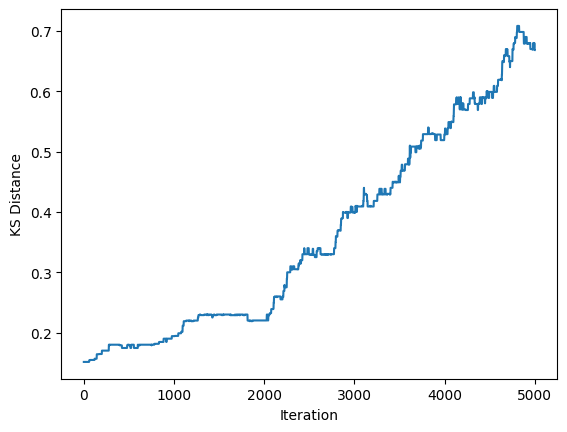

In [6]:
import matplotlib.pyplot as plt

plt.plot(logger.distances)
plt.xlabel('Iteration')
plt.ylabel('KS Distance')

acceptance_ratio = np.count_nonzero(logger.accept_rejects) / len(logger.distances)
print(f'Acceptance Ratio: {acceptance_ratio:.2%}')

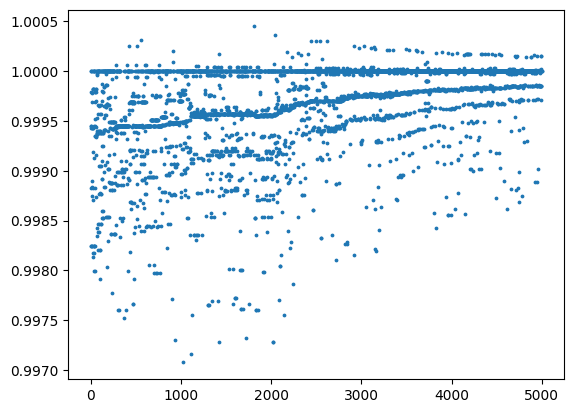

In [7]:
plt.scatter(np.arange(logger.iterations), np.array(logger.ratios) ** (1/exponent), s=3)